<a href="https://colab.research.google.com/github/RZdataprojects/Data-Mining---Rain-and-Bloom/blob/main/Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

In [24]:
import ee
import pandas as pd
import numpy as np
from pyproj import Proj, transform
import matplotlib.pyplot as plt
import folium
import shap
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

!gdown 1gYdg1N6V74A6uc_R99pIfFPGfA3T4gnG
!gdown 1N0qlqyCbHu2aIvmW7NLmEVueb87tNhKt
!gdown 1MxO35R9qEva5fws0T7o1HxwIwMGcfeQ5
!gdown 1N3ia-hJVSIUXLQYJ_WJzni33F_REi436

!unzip /content/IMS_2002-2023.zip

Downloading...
From: https://drive.google.com/uc?id=1gYdg1N6V74A6uc_R99pIfFPGfA3T4gnG
To: /content/IMS_2002-2023.zip
100% 10.9M/10.9M [00:00<00:00, 66.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1N0qlqyCbHu2aIvmW7NLmEVueb87tNhKt
To: /content/df with lat_long.csv
100% 274k/274k [00:00<00:00, 91.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MxO35R9qEva5fws0T7o1HxwIwMGcfeQ5
To: /content/pre-processed point.csv
100% 194k/194k [00:00<00:00, 76.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1N3ia-hJVSIUXLQYJ_WJzni33F_REi436
To: /content/ndvi_results.csv
100% 36.5M/36.5M [00:00<00:00, 60.7MB/s]
Archive:  /content/IMS_2002-2023.zip
replace IMS_2002.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

OBJECTID - Location ID


INDEX - Row ID


Slope_mt_neg2 - Slope (per what unit?)


mt_negev - Elevation


Litho - Stone Composition


category - 'Natural and Wooded' - identical to all rows


FNAME1 - Name in Hebrew


FTYPE_DESC - 'מעביר מים', 'נחל צר', 'נחל רחב', 'ערוצון/בתרון', 'תעלה'


STRM_ORD_1 - ?


FSTATUS_DE - Type of Stream ('זרימה בעיתות גשם - אכזב', 'מים', 'ניקוז', 'ערוץ מדומה')


POINT_X - latitude based on the Israeli TM Grid EPSG:2039


POINT_Y - longitude based on the Israeli TM Grid EPSG:2039

## Conversion from the Israeli TM Grid EPSG:2039 projection to Google's Earth prefered projection EPSG:4326

In [5]:
def convert_coordinates(x, y):
    # Define the EPSG:2039 and EPSG:4326 projections using pyproj Transformer
    proj2039 = Proj(init='epsg:2039')
    proj4326 = Proj(init='epsg:4326')

    # Convert EPSG:2039 to EPSG:4326
    lon, lat = transform(proj2039, proj4326, x, y)
    return lat, lon

# Apply the convert_coordinates function to create new columns
#df[['Latitude', 'Longitude']] = df.apply(lambda row: pd.Series(convert_coordinates(row['POINT_X'], row['POINT_Y'])), axis=1)
df_ = pd.read_csv('/content/df with lat_long.csv', index_col='INDEX')

In [6]:
df_.columns

Index(['OBJECTID', 'Slope_mt_neg2', 'mt_negev', 'Litho', 'category', 'FNAME1',
       'FTYPE_DESC', 'STRM_ORD_1', 'FSTATUS_DE', 'POINT_X', 'POINT_Y',
       'Latitude', 'Longitude'],
      dtype='object')

In [7]:
df_.columns = ['OBJECTID',	'Slope', 	'Elevation', 	'Litho', 	'category' ,	'FNAME1' ,	'FTYPE' 	,'STRM_ORD_1' ,	'FSTATUS_DE' ,	'POINT_X' ,	'POINT_Y' ,	'Latitude' ,	'Longitude']
df_.head(1)
#df.to_csv('df with lat_long')

,OBJECTID,Slope,Elevation,Litho,category,FNAME1,FTYPE,STRM_ORD_1,FSTATUS_DE,POINT_X,POINT_Y,Latitude,Longitude
INDEX,,,,,,,,,,,,,
1,1,7.235941,617.238037,Limestone/Dolomite/Marl,Natural and Wooded,,נחל צר,0.0,זרימה בעיתות גשם - אכזב,172983.9243,519275.619,30.763107,34.719044


## Removing features irrelevant/useless to the models: category (single unique value) and FNAME1 (location name in Hebrew).

In [8]:
# Get the outputs
nunique_output = df_.nunique()
count_output = df_.count()

# Concatenate the outputs into a single DataFrame
result_df = pd.concat([nunique_output, count_output, df_.isnull().sum()], axis=1)
result_df.columns = ['Unique Values', 'Count', 'null']
display(result_df)

,Unique Values,Count,null
OBJECTID,1431,1431,0
Slope,1431,1431,0
Elevation,1431,1431,0
Litho,6,1431,0
category,1,1431,0
FNAME1,36,1419,12
FTYPE,5,1419,12
STRM_ORD_1,7,1419,12
FSTATUS_DE,4,1419,12
POINT_X,1431,1431,0


In [9]:
# Removing Useless Features
df_.drop(columns=['category', 'FNAME1', 'FSTATUS_DE', 'POINT_X', 'POINT_Y'], inplace=True)

#Dealing with missing values - Removal of 12/1431 rows.
df_.dropna(axis=0, inplace=True)

# One-hot encode the 'Litho' and 'FTYPE' columns
df_ = pd.get_dummies(df_, columns=['Litho', 'FTYPE'])
df_.head()

,OBJECTID,Slope,Elevation,STRM_ORD_1,Latitude,Longitude,Litho_Alluvium,Litho_Chalk,Litho_Chert,Litho_Conglomerate,Litho_Limestone/Dolomite/Marl,Litho_Nubian sandstone,FTYPE_מעביר מים,FTYPE_נחל צר,FTYPE_נחל רחב,FTYPE_ערוצון/בתרון,FTYPE_תעלה
INDEX,,,,,,,,,,,,,,,,,
1,1,7.235941,617.238037,0.0,30.763107,34.719044,False,False,False,False,True,False,False,True,False,False,False
3,2,8.317689,597.649170,5.0,30.745758,34.708510,False,False,False,False,True,False,False,False,True,False,False
4,3,4.505186,635.804443,0.0,30.779991,34.691815,False,False,False,False,True,False,False,True,False,False,False
5,4,6.490717,625.075806,1.0,30.749266,34.694740,False,False,False,False,True,False,False,False,True,False,False
6,5,18.905861,591.240784,4.0,30.765798,34.723000,False,False,False,False,True,False,False,False,True,False,False


In [ ]:
#df_.to_csv('pre-processed point.csv')

## Getting Satelite Imagery (NDVI)

In [ ]:
from datetime import datetime
import ee
ee.Authenticate()
ee.Initialize(project='ee-roeiza')

In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# Assuming df_ is your DataFrame with columns ['Latitude'], ['Longitude']
# Create a date range from '2002-05-01' to '2024-01-01'
start_date = datetime(2002, 10, 30)
end_date = datetime(2024, 1, 1)
date_range = pd.date_range(start=start_date, end=end_date, freq='15D')

# Repeat the date range for each pair of Latitude and Longitude
dates_per_pair = len(date_range)
total_pairs = len(df_)
dates = date_range.tolist() * total_pairs

# Create a new DataFrame with dates, Latitude, and Longitude
new_data = {
    'OBJECTID': df_['OBJECTID'].repeat(dates_per_pair).reset_index(drop=True),
    'Date': dates[:dates_per_pair * total_pairs],
    'Latitude': df_['Latitude'].repeat(dates_per_pair).reset_index(drop=True),
    'Longitude': df_['Longitude'].repeat(dates_per_pair).reset_index(drop=True)
}
new_df_ = pd.DataFrame(new_data)

# Display the new DataFrame
display(new_df_)

,OBJECTID,Date,Latitude,Longitude
0,1,2002-10-30,30.763107,34.719044
1,1,2002-11-14,30.763107,34.719044
2,1,2002-11-29,30.763107,34.719044
3,1,2002-12-14,30.763107,34.719044
4,1,2002-12-29,30.763107,34.719044
...,...,...,...,...
732199,1431,2023-10-25,30.941668,34.901230
732200,1431,2023-11-09,30.941668,34.901230
732201,1431,2023-11-24,30.941668,34.901230
732202,1431,2023-12-09,30.941668,34.901230


In [ ]:
import numpy as np

# Define a function to convert DataFrame points to FeatureCollection
def convert_to_feature(point):
    return ee.Feature(ee.Geometry.Point(point['Longitude'], point['Latitude']))

# Define a function to calculate NDVI metrics for multiple points
def calculate_ndvi_metrics(point, start_date, end_date):
    # Convert points to a FeatureCollection
    features = ee.FeatureCollection(convert_to_feature(point))

    # Filter the image collection by date and bounds
    filtered_collection = ndvi_collection.filterBounds(features).filterDate(start_date, end_date)

    # Calculate NDVI
    def calculate_ndvi(image):
        ndvi = image.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename('NDVI')
        return image.addBands(ndvi)

    # Map NDVI calculation over the filtered collection
    ndvi_with_band = filtered_collection.map(calculate_ndvi)

    # Reduce the collection to get mean NDVI for each image
    ndvi_mean = ndvi_with_band.reduce(ee.Reducer.mean())

    # Get the NDVI values as a time series
    ndvi_values = ndvi_mean.select('NDVI_mean').reduceRegions(
        collection=features,
        reducer=ee.Reducer.mean(),
        scale=250,  # Adjust scale as needed
      )

    ndvi = ndvi_values.getInfo()['features'][0]['properties']['mean']
    #print(np.array([end_date, point.OBJECTID, point['Longitude'], point['Latitude'], ndvi]))
    #df_results = pd.DataFrame(ndvi_values.getInfo()['features'])
    return np.array([end_date, point.OBJECTID, point['Longitude'], point['Latitude'], ndvi])

# Load MODIS NDVI Image Collection
ndvi_collection = ee.ImageCollection('MODIS/061/MOD13Q1')

# Process each batch and concatenate results
df_results_list = []
for _,point in new_df_.iterrows():
    print(_)
    if _ % 150000 == 0:
        df = pd.DataFrame(df_results_list, columns=['Date', 'OBJECTID', 'Longitude', 'Latitude', 'NDVI'])
        df.to_csv(str(_) + '_.csv', index=False)
    start_date = str(point.Date)[:10]
    end_date = str((point.Date + pd.Timedelta(days=16)).date())
    try:
        df_results_batch = calculate_ndvi_metrics(point, start_date, end_date)
        df_results_list.append(df_results_batch)
    except:
        pass

df = pd.DataFrame(df_results_list, columns=['Date', 'OBJECTID', 'Longitude', 'Latitude', 'NDVI'])
# Export DataFrame to CSV or desired format
df.to_csv('ndvi_results.csv', index=False)

In [ ]:
# # Load an example image from the MODIS NDVI collection
# ndvi_collection = ee.ImageCollection('MODIS/MCD43A4_006_NDVI')
# example_image = ndvi_collection.first()

# # Fetch the image metadata
# image_info = example_image.getInfo()

# # Print the image metadata to see available properties
# print(image_info)

{'type': 'Image', 'bands': [{'id': 'NDVI', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': -1, 'max': 1}, 'crs': 'SR-ORG:6974', 'crs_transform': [463.312716528, 0, -20015109.354, 0, -463.312716527, 10007554.677]}], 'version': 1678890873869430.0, 'id': 'MODIS/MCD43A4_006_NDVI/2000_02_24', 'properties': {'system:time_start': 951350400000, 'system:time_end': 951436800000, 'system:index': '2000_02_24'}}


In [ ]:
# var point = Map.drawingTools().layers().get(0).getEeObject();

# // Define the date range from 2000 to 2005.
# var startDate = '2000-01-01';
# var endDate = '2005-12-31';

# // Load the MODIS image collection.
# var modis = ee.ImageCollection('MODIS/061/MOD13Q1')
#               .filterDate(startDate, endDate)
#               .select('NDVI');  // Selecting NDVI.

## Map Animation

In [11]:
# Points around Sde Boker

def add_points(map_obj, dataframe):
    for idx, row in dataframe.iterrows():
        lat, lon = row['Latitude'], row['Longitude']
        popup_content = f"""
        <strong>Name:</strong> {row['FNAME1']}<br>
        <strong>Longitude:</strong> {lon}<br>
        <strong>Latitude:</strong> {lat}<br>
        """
        folium.Marker([lat, lon], popup=popup_content).add_to(map_obj)

# Create a folium map centered at Sde Boker coordinates
sde_boker_lat, sde_boker_lon = 30.869830804375287, 34.79422640660065
map_center = [30.905, 34.79422640660065]
m = folium.Map(location=map_center, zoom_start=12)
df_ = pd.read_csv('/content/df with lat_long.csv', index_col='INDEX')
# Add marker for Sde Boker Weather Station
popup_sb = "<strong>Sde Boker Meteorological Station</strong><br>Coordinates: 30.8702, 34.7950"
folium.Marker([sde_boker_lat, sde_boker_lon], popup=popup_sb, icon=folium.Icon(color='red')).add_to(m)

# Add points from the DataFrame
add_points(m, df_)

# Display the map
m

In [ ]:
# NDVI animation

import geemap
Map = geemap.Map()

# Define the region of interest (ROI)
roi = Map.user_roi
if roi is None:
    roi = ee.Geometry.Rectangle([34, 29.2, 36, 33.5])
    Map.addLayer(roi)
    Map.centerObject(roi)

# Create the MODIS NDVI timelapse
timelapse = geemap.modis_ndvi_timelapse(
    roi,
    out_gif='ndvi.gif',
    data='Terra',
    band='NDVI',
    start_date='2002-01-01',
    end_date='2023-12-31',
    frames_per_second=3,
    title='MODIS NDVI Timelapse (%Y)',
    overlay_data='countries',
)

# Display the timelapse
geemap.show_image(timelapse)

## Pre-processing climate data

In [15]:
import pandas as pd
import os

# Define the directory path
directory = '/content/'

# Find all CSV files in the directory
csv_files = [file for file in os.listdir(directory) if (file.endswith('.csv')) and (file.startswith('IMS'))]
csv_files.sort()

# Merge CSV files into one big CSV
dfs = []
for file in csv_files:
    df = pd.read_csv(os.path.join(directory, file))
    dfs.append(df)
merged_csv = pd.concat(dfs, ignore_index=True)

# Rename Columns
merged_csv.columns = ['Station', 'Date', 'Mean Moisture', 'Mean Temp (C)', 'Max Temp (C)', 'Min Temp (C)', 'Mean Wind Speed (M/Sec)', 'Precipitation (mm)']

# Sort the DataFrame by the 'Date' column
merged_csv_sorted = merged_csv.sort_values(by='Date', ascending=True)

# Reset the index
merged_csv_sorted = merged_csv_sorted.reset_index(drop=True)

# Write the merged CSV to a file
merged_csv_sorted.to_csv(os.path.join(directory, 'merged_rain.csv'), index=False)

#merged_csv_sorted = pd.read_csv('/sise/home/roeiza/Data Mining/merged_rain.csv')
merged_csv_sorted.head()

,Station,Date,Mean Moisture,Mean Temp (C),Max Temp (C),Min Temp (C),Mean Wind Speed (M/Sec),Precipitation (mm)
0,שדה בוקר,01/01/2003 00:00,-,7.4,7.5,7.3,1.7,0
1,שדה בוקר,01/01/2003 00:00,-,7.4,7.5,7.3,1.7,0.0
2,שדה בוקר,01/01/2003 00:10,-,7.4,7.5,7.3,1.3,0
3,שדה בוקר,01/01/2003 00:20,-,7.1,7.4,6.8,1.6,0
4,שדה בוקר,01/01/2003 00:30,-,7,7.1,6.9,1.4,0


In [16]:
def only_date(date: str):
    return date[:10]

In [17]:
merged_csv_sorted.Date = merged_csv_sorted.Date.apply(lambda x: only_date(x))

In [18]:
merged_csv_sorted.head(1)

,Station,Date,Mean Moisture,Mean Temp (C),Max Temp (C),Min Temp (C),Mean Wind Speed (M/Sec),Precipitation (mm)
0,שדה בוקר,01/01/2003,-,7.4,7.5,7.3,1.7,0


In [19]:
import pandas as pd

# Replace '-' with NaN in the 'Mean Moisture' column
merged_csv_sorted = merged_csv_sorted.replace('-', float('nan'))

# Convert the Date column to datetime format if it's not already in that format
merged_csv_sorted['Date'] = pd.to_datetime(merged_csv_sorted['Date'], format='%d/%m/%Y')
merged_csv_sorted['Mean Moisture'] = merged_csv_sorted['Mean Moisture'].astype(float)
merged_csv_sorted['Mean Temp (C)'] = merged_csv_sorted['Mean Temp (C)'].astype(float)
merged_csv_sorted['Max Temp (C)'] = merged_csv_sorted['Max Temp (C)'].astype(float)
merged_csv_sorted['Min Temp (C)'] = merged_csv_sorted['Min Temp (C)'].astype(float)
merged_csv_sorted['Mean Wind Speed (M/Sec)'] = merged_csv_sorted['Mean Wind Speed (M/Sec)'].astype(float)
merged_csv_sorted['Precipitation (mm)'] = merged_csv_sorted['Precipitation (mm)'].astype(float)

# Define aggregation functions for each column
aggregation_functions = {
    'Station': 'first',
    'Mean Moisture': 'mean',
    'Mean Temp (C)': 'mean',
    'Max Temp (C)': 'max',
    'Min Temp (C)': 'min',
    'Mean Wind Speed (M/Sec)': 'mean',
    'Precipitation (mm)': 'sum'
}

# Group by the Date column and apply the aggregation functions
grouped_df = merged_csv_sorted.groupby('Date').agg(aggregation_functions).reset_index()

grouped_df.to_csv('grouped_df.csv')

# Print the first few rows of the grouped DataFrame
display(grouped_df.head(1))


,Date,Station,Mean Moisture,Mean Temp (C),Max Temp (C),Min Temp (C),Mean Wind Speed (M/Sec),Precipitation (mm)
0,2002-10-30,שדה בוקר,83.386364,19.661364,23.1,16.9,3.725,3.0


In [20]:
grouped_df['Month'] = pd.to_datetime(grouped_df.Date).dt.month
grouped_df['Year'] = pd.to_datetime(grouped_df.Date).dt.year

display(grouped_df.head(1))

,Date,Station,Mean Moisture,Mean Temp (C),Max Temp (C),Min Temp (C),Mean Wind Speed (M/Sec),Precipitation (mm),Month,Year
0,2002-10-30,שדה בוקר,83.386364,19.661364,23.1,16.9,3.725,3.0,10,2002


In [21]:
# Group by 'Month' and calculate the mean for each month
monthly_means = grouped_df.loc[:,grouped_df.columns[2:9]].groupby('Month').mean()

# Fill NaN values in all columns with the corresponding monthly mean
for col in grouped_df.columns[2:8]:
    if col != 'Month':
        grouped_df[col] = grouped_df.apply(lambda row: monthly_means.loc[row['Month'], col] if pd.isna(row[col]) else row[col], axis=1)

grouped_df.drop(columns=['Month','Year','Mean Temp (C)'], inplace=True)
# Print the updated DataFrame to verify the changes
display(grouped_df.head(1))

,Date,Station,Mean Moisture,Max Temp (C),Min Temp (C),Mean Wind Speed (M/Sec),Precipitation (mm)
0,2002-10-30,שדה בוקר,83.386364,23.1,16.9,3.725,3.0


In [22]:
df1 = grouped_df
df1['Date'] = pd.to_datetime(df1['Date'])
del grouped_df

# Combining to NDVI

In [ ]:
df2 = pd.read_csv('/content/ndvi_results.csv')
df2['Start Date'] = pd.to_datetime(df2['Date']) - pd.DateOffset(days=14)
df2['Start Date'] = df2['Start Date'].dt.strftime('%Y-%m-%d')
df2['Date'] = pd.to_datetime(df2['Date'])
df2['Start Date'] = pd.to_datetime(df2['Start Date'])
display(df2.head(1))

In [ ]:
df2 = pd.merge(left=df2, right=df_, left_on='OBJECTID', right_on='OBJECTID')
df2.drop(columns=['Latitude_y', 'Longitude_y'], inplace=True)
df2.columns= ['Date', 'OBJECTID', 'Longitude', 'Latitude', 'NDVI', 'Start Date',
       'Slope', 'Elevation', 'STRM_ORD_1', 'Litho_Alluvium', 'Litho_Chalk',
       'Litho_Chert', 'Litho_Conglomerate', 'Litho_Limestone/Dolomite/Marl',
       'Litho_Nubian sandstone', 'FTYPE_מעביר מים', 'FTYPE_נחל צר',
       'FTYPE_נחל רחב', 'FTYPE_ערוצון/בתרון', 'FTYPE_תעלה']
df2.head(1)

,Date,OBJECTID,Longitude,Latitude,NDVI,Start Date,Slope,Elevation,STRM_ORD_1,Litho_Alluvium,Litho_Chalk,Litho_Chert,Litho_Conglomerate,Litho_Limestone/Dolomite/Marl,Litho_Nubian sandstone,FTYPE_מעביר מים,FTYPE_נחל צר,FTYPE_נחל רחב,FTYPE_ערוצון/בתרון,FTYPE_תעלה
0,2002-11-13,1,34.719044,30.763107,995.0,2002-10-30,7.235941,617.238037,0.0,False,False,False,False,True,False,False,True,False,False,False


In [ ]:
import duckdb

df = duckdb.query("""
                  SELECT
                  df1.Date as Date,
                  df2.OBJECTID as OBJECTID,
                  df2['Start Date'] as 'Start Date',
                  df2['Date'] as 'End Date',
                  df2.Longitude,
                  df2.Latitude,
                  df2.Slope,
                  df2.Elevation,
                  df2.STRM_ORD_1,
                  df2.Litho_Alluvium,
                  df2.Litho_Chalk,
                  df2.Litho_Chert,
                  df2.Litho_Conglomerate,
                  df2['Litho_Limestone/Dolomite/Marl'] as 'Litho_Limestone/Dolomite/Marl',
                  df2['Litho_Nubian sandstone'] as 'Litho_Nubian sandstone',
                  df2['FTYPE_מעביר מים'] as 'FTYPE_מעביר מים',
                  df2['FTYPE_נחל צר'] as 'FTYPE_נחל צר',
                  df2['FTYPE_נחל רחב'] as 'FTYPE_נחל רחב',
                  df2['FTYPE_ערוצון/בתרון'] as 'FTYPE_ערוצון/בתרון',
                  df2['FTYPE_תעלה'] as 'FTYPE_תעלה',
                  df1['Mean Moisture'] as 'Mean Moisture',
                  df1['Max Temp (C)'] as 'Max Temp (C)',
                  df1['Min Temp (C)'] as 'Min Temp (C)',
                  df1['Mean Wind Speed (M/Sec)'] as 'Mean Wind Speed (M/Sec)',
                  df1['Precipitation (mm)'] as 'Precipitation (mm)',
                  NDVI
                  FROM df1 JOIN df2
                     on df1.Date >= df2['Start Date'] and df1.Date <= df2.Date
                  ORDER BY 1 ASC
                  """).df()
display(df)

,Date,OBJECTID,Start Date,End Date,Longitude,Latitude,Slope,Elevation,STRM_ORD_1,Litho_Alluvium,...,FTYPE_נחל צר,FTYPE_נחל רחב,FTYPE_ערוצון/בתרון,FTYPE_תעלה,Mean Moisture,Max Temp (C),Min Temp (C),Mean Wind Speed (M/Sec),Precipitation (mm),NDVI
0,2002-10-30,1139,2002-10-30,2002-11-13,34.877741,30.891273,9.385620,602.136963,2.0,False,...,True,False,False,False,83.386364,23.1,16.9,3.725,3.0,1028.0
1,2002-10-30,1140,2002-10-30,2002-11-13,34.875313,30.874830,18.746786,616.236328,2.0,False,...,True,False,False,False,83.386364,23.1,16.9,3.725,3.0,1062.0
2,2002-10-30,1141,2002-10-30,2002-11-13,34.866718,30.933320,3.511221,527.366577,1.0,False,...,True,False,False,False,83.386364,23.1,16.9,3.725,3.0,862.0
3,2002-10-30,1142,2002-10-30,2002-11-13,34.834559,30.917058,7.760821,578.682068,0.0,False,...,True,False,False,False,83.386364,23.1,16.9,3.725,3.0,955.0
4,2002-10-30,1143,2002-10-30,2002-11-13,34.815339,30.908602,11.407053,578.625366,0.0,False,...,True,False,False,False,83.386364,23.1,16.9,3.725,3.0,966.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9671899,2024-01-01,452,2023-12-24,2024-01-07,34.672978,30.847780,7.310047,493.062164,1.0,False,...,True,False,False,False,92.000000,9.3,8.7,0.900,0.0,1215.0
9671900,2024-01-01,453,2023-12-24,2024-01-07,34.656648,30.815328,1.862491,419.493744,1.0,False,...,True,False,False,False,92.000000,9.3,8.7,0.900,0.0,955.0
9671901,2024-01-01,454,2023-12-24,2024-01-07,34.647678,30.857715,10.746629,395.034515,1.0,False,...,True,False,False,False,92.000000,9.3,8.7,0.900,0.0,1331.0
9671902,2024-01-01,455,2023-12-24,2024-01-07,34.669016,30.814459,9.948986,446.744507,4.0,False,...,True,False,False,False,92.000000,9.3,8.7,0.900,0.0,1154.0


In [ ]:
df.columns

Index(['Date', 'OBJECTID', 'Start Date', 'End Date', 'Longitude', 'Latitude',
       'Slope', 'Elevation', 'STRM_ORD_1', 'Litho_Alluvium', 'Litho_Chalk',
       'Litho_Chert', 'Litho_Conglomerate', 'Litho_Limestone/Dolomite/Marl',
       'Litho_Nubian sandstone', 'FTYPE_מעביר מים', 'FTYPE_נחל צר',
       'FTYPE_נחל רחב', 'FTYPE_ערוצון/בתרון', 'FTYPE_תעלה', 'Mean Moisture',
       'Max Temp (C)', 'Min Temp (C)', 'Mean Wind Speed (M/Sec)',
       'Precipitation (mm)', 'NDVI'],
      dtype='object')

In [ ]:
aggregation_functions = {
    'Max Temp (C)': 'mean',
    'Min Temp (C)': 'mean',
    'Mean Moisture':'mean',
    'Mean Wind Speed (M/Sec)': 'mean',
    'Precipitation (mm)': 'sum'
    }
# Group by the Date column and apply the aggregation functions\n",

grouped_df = df.groupby(['Start Date', 'End Date', 'OBJECTID', 'Longitude', 'Latitude', 'Slope',
       'Elevation', 'STRM_ORD_1', 'Litho_Alluvium', 'Litho_Chalk',
       'Litho_Chert', 'Litho_Conglomerate', 'Litho_Limestone/Dolomite/Marl',
       'Litho_Nubian sandstone', 'FTYPE_מעביר מים', 'FTYPE_נחל צר',
       'FTYPE_נחל רחב', 'FTYPE_ערוצון/בתרון', 'FTYPE_תעלה', 'NDVI']).agg(aggregation_functions).reset_index()
display(grouped_df)

,Start Date,End Date,OBJECTID,Longitude,Latitude,Slope,Elevation,STRM_ORD_1,Litho_Alluvium,Litho_Chalk,...,FTYPE_נחל צר,FTYPE_נחל רחב,FTYPE_ערוצון/בתרון,FTYPE_תעלה,NDVI,Max Temp (C),Min Temp (C),Mean Moisture,Mean Wind Speed (M/Sec),Precipitation (mm)
0,2002-10-30,2002-11-13,1,34.719044,30.763107,7.235941,617.238037,0.0,False,False,...,True,False,False,False,995.0,23.733333,12.833333,69.663153,2.471250,10.0
1,2002-10-30,2002-11-13,2,34.708510,30.745758,8.317689,597.649170,5.0,False,False,...,False,True,False,False,953.0,23.733333,12.833333,69.663153,2.471250,10.0
2,2002-10-30,2002-11-13,3,34.691815,30.779991,4.505186,635.804443,0.0,False,False,...,True,False,False,False,876.0,23.733333,12.833333,69.663153,2.471250,10.0
3,2002-10-30,2002-11-13,4,34.694740,30.749266,6.490717,625.075806,1.0,False,False,...,False,True,False,False,943.0,23.733333,12.833333,69.663153,2.471250,10.0
4,2002-10-30,2002-11-13,5,34.723000,30.765798,18.905861,591.240784,4.0,False,False,...,False,True,False,False,1020.0,23.733333,12.833333,69.663153,2.471250,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645640,2023-12-24,2024-01-07,1427,34.821567,30.985778,18.534872,438.050079,1.0,False,True,...,True,False,False,False,1319.0,18.311111,8.233333,70.360340,2.086574,0.0
645641,2023-12-24,2024-01-07,1428,34.813676,30.977705,5.907411,450.016785,3.0,False,False,...,True,False,False,False,1366.0,18.311111,8.233333,70.360340,2.086574,0.0
645642,2023-12-24,2024-01-07,1429,34.899672,30.951320,5.092325,517.312622,0.0,False,False,...,True,False,False,False,1376.0,18.311111,8.233333,70.360340,2.086574,0.0
645643,2023-12-24,2024-01-07,1430,34.906650,30.944802,6.929229,574.304688,0.0,False,False,...,True,False,False,False,1405.0,18.311111,8.233333,70.360340,2.086574,0.0


In [ ]:
grouped_df.sort_values(by=['OBJECTID', 'Start Date']).to_csv('./final_ds.csv', index=False)

# Models

In [ ]:
grouped_df = pd.read_csv('./final_ds.csv')
grouped_df.columns = ['Start Date', 'End Date', 'OBJECTID', 'Longitude',
       'Latitude', 'Slope',
       'Elevation', 'STRM_ORD_1', 'Litho_Alluvium', 'Litho_Chalk',
       'Litho_Chert', 'Litho_Conglomerate', 'Litho_Limestone/Dolomite/Marl',
       'Litho_Nubian sandstone', 'FTYPE_Water Channel', 'FTYPE_Narrow Stream',
       'FTYPE_Wide Stream', 'FTYPE_Gulp', 'FTYPE_Canal', 'NDVI',
       'Max Temp (C)', 'Min Temp (C)', 'Mean Moisture',
       'Mean Wind Speed (M/Sec)', 'Precipitation (mm)']

In [ ]:
for lag in range(1, 10):
    grouped_df[f'NDVI_Lag_{lag}'] = grouped_df['NDVI'].shift(lag)
grouped_df.dropna(inplace=True)
display(grouped_df.head(1))

,Start Date,End Date,OBJECTID,Longitude,Latitude,Slope,Elevation,STRM_ORD_1,Litho_Alluvium,Litho_Chalk,...,Precipitation (mm),NDVI_Lag_1,NDVI_Lag_2,NDVI_Lag_3,NDVI_Lag_4,NDVI_Lag_5,NDVI_Lag_6,NDVI_Lag_7,NDVI_Lag_8,NDVI_Lag_9
9,2003-03-14,2003-03-28,1,34.719044,30.763107,7.235941,617.238037,0.0,False,False,...,10.4,1254.0,1166.0,1258.0,1187.0,1195.0,1249.0,1188.0,1024.0,995.0


In [ ]:
grouped_df.columns

Index(['Start Date', 'End Date', 'OBJECTID', 'Longitude', 'Latitude', 'Slope',
       'Elevation', 'STRM_ORD_1', 'Litho_Alluvium', 'Litho_Chalk',
       'Litho_Chert', 'Litho_Conglomerate', 'Litho_Limestone/Dolomite/Marl',
       'Litho_Nubian sandstone', 'FTYPE_Water Channel', 'FTYPE_Narrow Stream',
       'FTYPE_Wide Stream', 'FTYPE_Gulp', 'FTYPE_Canal', 'NDVI',
       'Max Temp (C)', 'Min Temp (C)', 'Mean Moisture',
       'Mean Wind Speed (M/Sec)', 'Precipitation (mm)', 'NDVI_Lag_1',
       'NDVI_Lag_2', 'NDVI_Lag_3', 'NDVI_Lag_4', 'NDVI_Lag_5', 'NDVI_Lag_6',
       'NDVI_Lag_7', 'NDVI_Lag_8', 'NDVI_Lag_9'],
      dtype='object')

In [ ]:
data_for_model_NDVI = grouped_df[['Slope',
       'Elevation', 'STRM_ORD_1', 'Litho_Alluvium', 'Litho_Chalk',
       'Litho_Chert', 'Litho_Conglomerate', 'Litho_Limestone/Dolomite/Marl',
       'Litho_Nubian sandstone', 'FTYPE_Water Channel', 'FTYPE_Narrow Stream',
       'FTYPE_Wide Stream', 'FTYPE_Gulp', 'FTYPE_Canal',
       'Max Temp (C)', 'Min Temp (C)', 'Mean Moisture',
       'Mean Wind Speed (M/Sec)', 'Precipitation (mm)', 'NDVI']].iloc[:, :]
data_for_model_NDVI_Lag_1 = grouped_df[['Slope',
       'Elevation', 'STRM_ORD_1', 'Litho_Alluvium', 'Litho_Chalk',
       'Litho_Chert', 'Litho_Conglomerate', 'Litho_Limestone/Dolomite/Marl',
       'Litho_Nubian sandstone', 'FTYPE_Water Channel', 'FTYPE_Narrow Stream',
       'FTYPE_Wide Stream', 'FTYPE_Gulp', 'FTYPE_Canal',
       'Max Temp (C)', 'Min Temp (C)', 'Mean Moisture',
       'Mean Wind Speed (M/Sec)', 'Precipitation (mm)', 'NDVI_Lag_1']].iloc[1:, :]
data_for_model_NDVI_Lag_2 = grouped_df[['Slope',
       'Elevation', 'STRM_ORD_1', 'Litho_Alluvium', 'Litho_Chalk',
       'Litho_Chert', 'Litho_Conglomerate', 'Litho_Limestone/Dolomite/Marl',
       'Litho_Nubian sandstone', 'FTYPE_Water Channel', 'FTYPE_Narrow Stream',
       'FTYPE_Wide Stream', 'FTYPE_Gulp', 'FTYPE_Canal',
       'Max Temp (C)', 'Min Temp (C)', 'Mean Moisture',
       'Mean Wind Speed (M/Sec)', 'Precipitation (mm)', 'NDVI_Lag_2']].iloc[2:, :]
data_for_model_NDVI_Lag_3 = grouped_df[['Slope',
       'Elevation', 'STRM_ORD_1', 'Litho_Alluvium', 'Litho_Chalk',
       'Litho_Chert', 'Litho_Conglomerate', 'Litho_Limestone/Dolomite/Marl',
       'Litho_Nubian sandstone', 'FTYPE_Water Channel', 'FTYPE_Narrow Stream',
       'FTYPE_Wide Stream', 'FTYPE_Gulp', 'FTYPE_Canal',
       'Max Temp (C)', 'Min Temp (C)', 'Mean Moisture',
       'Mean Wind Speed (M/Sec)', 'Precipitation (mm)', 'NDVI_Lag_3']].iloc[3:, :]
data_for_model_NDVI_Lag_4 = grouped_df[['Slope',
       'Elevation', 'STRM_ORD_1', 'Litho_Alluvium', 'Litho_Chalk',
       'Litho_Chert', 'Litho_Conglomerate', 'Litho_Limestone/Dolomite/Marl',
       'Litho_Nubian sandstone', 'FTYPE_Water Channel', 'FTYPE_Narrow Stream',
       'FTYPE_Wide Stream', 'FTYPE_Gulp', 'FTYPE_Canal',
       'Max Temp (C)', 'Min Temp (C)', 'Mean Moisture',
       'Mean Wind Speed (M/Sec)', 'Precipitation (mm)', 'NDVI_Lag_4']].iloc[4:, :]
data_for_model_NDVI_Lag_5 = grouped_df[['Slope',
       'Elevation', 'STRM_ORD_1', 'Litho_Alluvium', 'Litho_Chalk',
       'Litho_Chert', 'Litho_Conglomerate', 'Litho_Limestone/Dolomite/Marl',
       'Litho_Nubian sandstone', 'FTYPE_Water Channel', 'FTYPE_Narrow Stream',
       'FTYPE_Wide Stream', 'FTYPE_Gulp', 'FTYPE_Canal',
       'Max Temp (C)', 'Min Temp (C)', 'Mean Moisture',
       'Mean Wind Speed (M/Sec)', 'Precipitation (mm)', 'NDVI_Lag_5']].iloc[5:, :]
data_for_model_NDVI_Lag_6 = grouped_df[['Slope',
       'Elevation', 'STRM_ORD_1', 'Litho_Alluvium', 'Litho_Chalk',
       'Litho_Chert', 'Litho_Conglomerate', 'Litho_Limestone/Dolomite/Marl',
       'Litho_Nubian sandstone', 'FTYPE_Water Channel', 'FTYPE_Narrow Stream',
       'FTYPE_Wide Stream', 'FTYPE_Gulp', 'FTYPE_Canal',
       'Max Temp (C)', 'Min Temp (C)', 'Mean Moisture',
       'Mean Wind Speed (M/Sec)', 'Precipitation (mm)', 'NDVI_Lag_6']].iloc[6:, :]
data_for_model_NDVI_Lag_7 = grouped_df[['Slope',
       'Elevation', 'STRM_ORD_1', 'Litho_Alluvium', 'Litho_Chalk',
       'Litho_Chert', 'Litho_Conglomerate', 'Litho_Limestone/Dolomite/Marl',
       'Litho_Nubian sandstone', 'FTYPE_Water Channel', 'FTYPE_Narrow Stream',
       'FTYPE_Wide Stream', 'FTYPE_Gulp', 'FTYPE_Canal',
       'Max Temp (C)', 'Min Temp (C)', 'Mean Moisture',
       'Mean Wind Speed (M/Sec)', 'Precipitation (mm)', 'NDVI_Lag_7']].iloc[7:, :]
data_for_model_NDVI_Lag_8 = grouped_df[['Slope',
       'Elevation', 'STRM_ORD_1', 'Litho_Alluvium', 'Litho_Chalk',
       'Litho_Chert', 'Litho_Conglomerate', 'Litho_Limestone/Dolomite/Marl',
       'Litho_Nubian sandstone', 'FTYPE_Water Channel', 'FTYPE_Narrow Stream',
       'FTYPE_Wide Stream', 'FTYPE_Gulp', 'FTYPE_Canal',
       'Max Temp (C)', 'Min Temp (C)', 'Mean Moisture',
       'Mean Wind Speed (M/Sec)', 'Precipitation (mm)', 'NDVI_Lag_8']].iloc[8:, :]
data_for_model_NDVI_Lag_9 = grouped_df[['Slope',
       'Elevation', 'STRM_ORD_1', 'Litho_Alluvium', 'Litho_Chalk',
       'Litho_Chert', 'Litho_Conglomerate', 'Litho_Limestone/Dolomite/Marl',
       'Litho_Nubian sandstone', 'FTYPE_Water Channel', 'FTYPE_Narrow Stream',
       'FTYPE_Wide Stream', 'FTYPE_Gulp', 'FTYPE_Canal',
       'Max Temp (C)', 'Min Temp (C)', 'Mean Moisture',
       'Mean Wind Speed (M/Sec)', 'Precipitation (mm)', 'NDVI_Lag_9']].iloc[9:, :]
results = pd.DataFrame()
results['n'] = 0
results['r2'] = 0
results['mae'] = 0
results['mse'] = 0

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Split the data into features and target variable
X = data_for_model_NDVI.drop("NDVI", axis=1)
y = data_for_model_NDVI["NDVI"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an XGBoost regression model
model = XGBRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

results.loc[0, 'n'] = 0
results.loc[0, 'r2'] = r2
results.loc[0, 'mae'] = mae
results.loc[0, 'mse'] = mse

# Split the data into features and target variable
X = data_for_model_NDVI_Lag_1.drop("NDVI_Lag_1", axis=1)
y = data_for_model_NDVI_Lag_1["NDVI_Lag_1"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an XGBoost regression model
model = XGBRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

results.loc[1, 'n'] = 1
results.loc[1, 'r2'] = r2
results.loc[1, 'mae'] = mae
results.loc[1, 'mse'] = mse

X = data_for_model_NDVI_Lag_2.drop("NDVI_Lag_2", axis=1)
y = data_for_model_NDVI_Lag_2["NDVI_Lag_2"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an XGBoost regression model
model = XGBRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

results.loc[2, 'n'] = 2
results.loc[2, 'r2'] = r2
results.loc[2, 'mae'] = mae
results.loc[2, 'mse'] = mse

# Split the data into features and target variable
X = data_for_model_NDVI_Lag_3.drop("NDVI_Lag_3", axis=1)
y = data_for_model_NDVI_Lag_3["NDVI_Lag_3"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an XGBoost regression model
model = XGBRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

results.loc[3, 'n'] = 3
results.loc[3, 'r2'] = r2
results.loc[3, 'mae'] = mae
results.loc[3, 'mse'] = mse

# Split the data into features and target variable
X = data_for_model_NDVI_Lag_4.drop("NDVI_Lag_4", axis=1)
y = data_for_model_NDVI_Lag_4["NDVI_Lag_4"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an XGBoost regression model
model = XGBRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

results.loc[4, 'n'] = 4
results.loc[4, 'r2'] = r2
results.loc[4, 'mae'] = mae
results.loc[4, 'mse'] = mse

# Split the data into features and target variable
X = data_for_model_NDVI_Lag_5.drop("NDVI_Lag_5", axis=1)
y = data_for_model_NDVI_Lag_5["NDVI_Lag_5"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an XGBoost regression model
model = XGBRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

results.loc[5, 'n'] = 5
results.loc[5, 'r2'] = r2
results.loc[5, 'mae'] = mae
results.loc[5, 'mse'] = mse

# Split the data into features and target variable
X = data_for_model_NDVI_Lag_6.drop("NDVI_Lag_6", axis=1)
y = data_for_model_NDVI_Lag_6["NDVI_Lag_6"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an XGBoost regression model
model = XGBRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

results.loc[6, 'n'] = 6
results.loc[6, 'r2'] = r2
results.loc[6, 'mae'] = mae
results.loc[6, 'mse'] = mse

In [ ]:
display(results)

,n,r2,mae,mse
0,0.0,0.727199,57.756375,7899.862836
1,1.0,0.727779,57.754875,7841.013052
2,2.0,0.727208,57.981490,7835.295714
3,3.0,0.730269,57.542777,7751.253012
4,4.0,0.721316,58.353577,7962.397764
5,5.0,0.718255,58.384267,8101.787160
6,6.0,0.709937,59.227184,8573.608537


In [ ]:
# Best Model N=0

# Split the data into features and target variable
X = data_for_model_NDVI.drop("NDVI", axis=1)
y = data_for_model_NDVI["NDVI"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an XGBoost regression model
model = XGBRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# SHAP

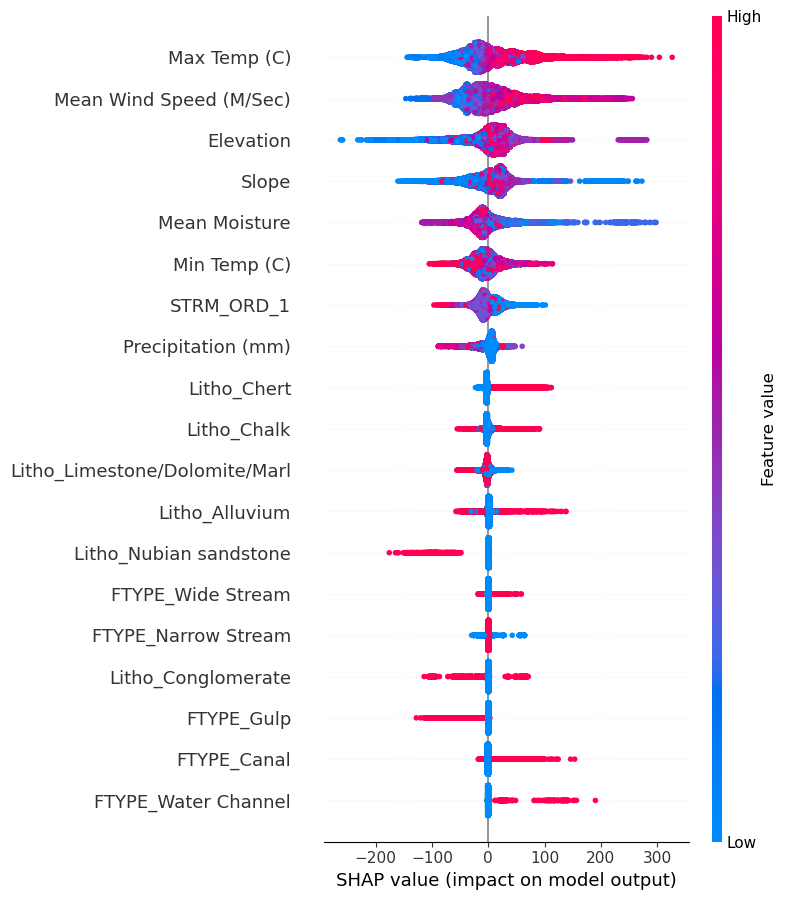

In [ ]:
import shap

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=50)

In [ ]:
# Define the number of features and create a grid layout
num_features = X_test.shape[1]
cols = X_test.columns

In [ ]:
# Create a grid of subplots for each feature interaction
fig, axs = plt.subplots(18, 2, figsize=(10, 100))
for j in range(18,19):
    # Plot each feature interaction on the grid
    for i in range(0, 19):
        if i<j:
            # Plot on the first subplot
            shap.dependence_plot(cols[j], shap_values, X_test, interaction_index=i, ax=axs[i-0, 0], alpha=0.1, show=False)
            shap.dependence_plot(cols[i], shap_values, X_test, interaction_index=j, ax=axs[i-0, 1], alpha=0.1, show=False)
        elif i>j:
            # Plot on the first subplot
            shap.dependence_plot(cols[j], shap_values, X_test, interaction_index=i, ax=axs[i-1, 0], alpha=0.1, show=False)
            shap.dependence_plot(cols[i], shap_values, X_test, interaction_index=j, ax=axs[i-1, 1], alpha=0.1, show=False)
        else:
            continue
    # Adjust spacing and display the plot
    plt.subplots_adjust(wspace=0.5)  # Increase the width space between columns
    col_name = cols[j].replace('/', '_')
    plt.savefig('./' + col_name + '.png')
    plt.close()
    break

In [ ]:
# Convert SHAP values to DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

In [ ]:
# Reversed and Scaled Feature Dependency
fig, axs = plt.subplots(18, 2, figsize=(10, 100))
for j in range(18, 19):
    # Plot each feature interaction on the grid
    for i in range(0, 19):
        if i < j:
            # Plot on the first subplot
            scatter_plot_1 = axs[i, 0].scatter(X_test.iloc[:, j], X_test.iloc[:, i], c=shap_values[:, j], cmap='magma', vmin=-25, vmax=80, alpha=0.1)
            axs[i, 0].set_xlabel(X_test.columns[j])
            axs[i, 0].set_ylabel(X_test.columns[i] + ' (interaction with ' + X_test.columns[j] + ')')
            axs[i, 0].set_title('SHAP Values for ' + X_test.columns[j])
            plt.colorbar(scatter_plot_1, ax=axs[i, 0], label='SHAP Values for ' + X_test.columns[j])

            # Plot on the second subplot
            scatter_plot_2 = axs[i, 1].scatter(X_test.iloc[:, i], X_test.iloc[:, j], c=shap_values[:, i], cmap='magma', vmin=-25, vmax=80, alpha=0.1)
            axs[i, 1].set_xlabel(X_test.columns[i] + ' (interaction with ' + X_test.columns[j] + ')')
            axs[i, 1].set_ylabel(X_test.columns[j])
            axs[i, 1].set_title('SHAP Values for ' + X_test.columns[i])
            plt.colorbar(scatter_plot_2, ax=axs[i, 1], label='SHAP Values for ' + X_test.columns[i])
        elif i > j:
            # Plot on the first subplot
            scatter_plot_1 = axs[i-1, 0].scatter(X_test.iloc[:, j], X_test.iloc[:, i], c=shap_values[:, j], cmap='magma', vmin=-25, vmax=80, alpha=0.1)
            axs[i-1, 0].set_xlabel(X_test.columns[j])
            axs[i-1, 0].set_ylabel(X_test.columns[i] + ' (interaction with ' + X_test.columns[j] + ')')
            axs[i-1, 0].set_title('SHAP Values for ' + X_test.columns[j])
            plt.colorbar(scatter_plot_1, ax=axs[i-1, 0], label='SHAP Values for ' + X_test.columns[j])

            # Plot on the second subplot
            scatter_plot_2 = axs[i-1, 1].scatter(X_test.iloc[:, i], X_test.iloc[:, j], c=shap_values[:, i], cmap='magma', vmin=-25, vmax=80, alpha=0.1)
            axs[i-1, 1].set_xlabel(X_test.columns[i] + ' (interaction with ' + X_test.columns[j] + ')')
            axs[i-1, 1].set_ylabel(X_test.columns[j])
            axs[i-1, 1].set_title('SHAP Values for ' + X_test.columns[i])
            plt.colorbar(scatter_plot_2, ax=axs[i-1, 1], label='SHAP Values for ' + X_test.columns[i])
        else:
            continue
    print(cols[j])
    # Adjust spacing and display the plot
    plt.subplots_adjust(wspace=0.5)  # Increase the width space between columns
    col_name = cols[j].replace('/', '_')
    plt.savefig('./' + col_name + '_Reversed and Scaled.png')
    plt.close()
    break

Precipitation (mm)


In [ ]:
# Generate SHAP force plot for the first instance in the test data
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

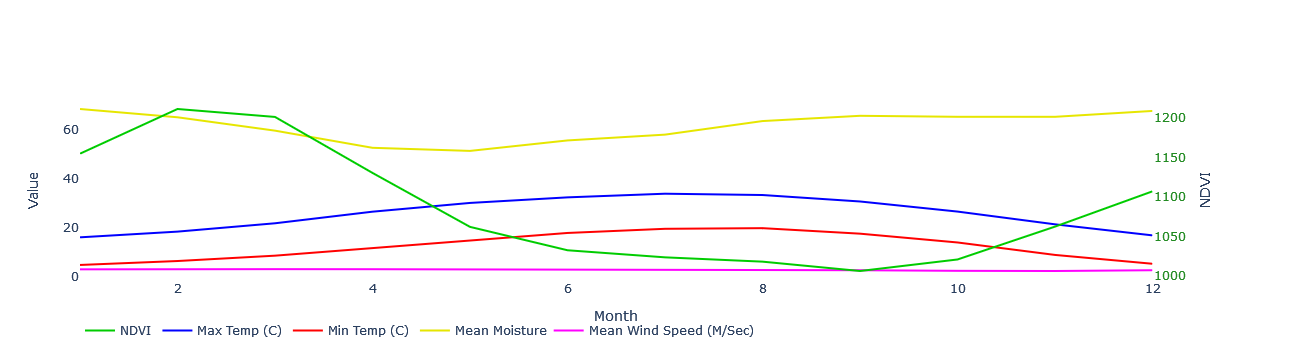

In [ ]:
# Plotly Average Monthly Distribution of Variables (2002-2023)

import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load the data
data = pd.read_csv('./final_ds.csv', usecols=['Start Date','NDVI','Max Temp (C)','Min Temp (C)','Mean Moisture','Mean Wind Speed (M/Sec)','Precipitation (mm)'])

# Convert 'Start Date' to datetime format
data['Start Date'] = pd.to_datetime(data['Start Date'])

# Extract month from 'Start Date'
data['Month'] = data['Start Date'].dt.month
#data['Year'] = data['Start Date'].dt.year

# Group by month and calculate the mean
monthly_means = data.groupby(['Month']).mean()
monthly_means.drop(columns=['Start Date'], inplace=True)
monthly_means.reset_index(inplace=True)

# Load the data (replace this with your actual data)
data = monthly_means

# Create a Plotly figure
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Define a custom brightened royal color palette
bright_royal_palette = [
    '#00cc00', '#0000ff', '#ff0000', '#e6e600', '#ff00ff', '#ff6600']

# Add traces for each numerical column
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
for i, column in zip(range(len(numerical_columns)), numerical_columns[:-1]):
    if column != 'NDVI':
        fig.add_trace(go.Scatter(x=data['Month'], y=data[column], mode='lines', name=column, line=dict(color=bright_royal_palette[i])), secondary_y=False)
    else:
        fig.add_trace(go.Scatter(x=data['Month'], y=data[column], mode='lines', name=column, line=dict(color=bright_royal_palette[i])), secondary_y=True)

# Update layout for the plot
fig.update_layout(
    title_text='',#Average Monthly Distribution of Variables (2002-2023)',
    title_x=0.5,  # Center the title
    xaxis=dict(title='Month', range=[1, 12]),
    yaxis=dict(title='Value'),  # Removed y-axis tick color customization
    yaxis2=dict(title='NDVI', overlaying='y', side='right', tickfont=dict(color='forestgreen')),  # Customize secondary y-axis tick color
    legend=dict(x=0, y=-0.2, orientation='h'),  # Place legend at the bottom
    plot_bgcolor='white',  # Set plot background color
    paper_bgcolor='rgba(0,0,0,0)',  # Set paper background color (transparent)
    colorway=bright_royal_palette  # Apply the custom brightened royal color palette
)

# Show the interactive plot
fig.show()

In [ ]:
#Plotly Distribution of NDVI per Month
import plotly.graph_objects as go

# Load the data
data = pd.read_csv('./final_ds.csv', usecols=['Start Date','NDVI','Max Temp (C)','Min Temp (C)','Mean Moisture','Mean Wind Speed (M/Sec)','Precipitation (mm)'])

# Convert 'Start Date' to datetime format
data['Start Date'] = pd.to_datetime(data['Start Date'])

# Extract month from 'Start Date'
data['Month'] = data['Start Date'].dt.month

# Create a Plotly figure for box plot
fig = go.Figure()

# Add box plot for NDVI distribution per month
fig.add_trace(go.Box(
    x=data['Month'],  # X-axis: Month
    y=data['NDVI'],  # Y-axis: NDVI values
    name='NDVI Distribution',
    boxmean=True  # Show the mean in the box plot
))

# Update layout for the plot
fig.update_layout(
    title_text='Distribution of NDVI per Month',
    xaxis=dict(title='Month'),
    yaxis=dict(title='NDVI'),
    plot_bgcolor='white',  # Set plot background color
    paper_bgcolor='rgba(0,0,0,0)',  # Set paper background color (transparent)
)

# Show the interactive plot
fig.show()


In [ ]:
monthly_means['diff'] = monthly_means['NDVI']-monthly_means['NDVI'].mean()

In [ ]:
monthly

,Year,Month,NDVI,Max Temp (C),Min Temp (C),Mean Moisture,Mean Wind Speed (M/Sec),Precipitation (mm),diff
0,2002,10,1018.026779,23.733333,12.833333,69.663153,2.471250,10.00,-68.274821
1,2002,11,1130.561311,20.753333,9.026667,65.278144,2.989699,5.80,44.259710
2,2002,12,1251.729739,17.336667,6.460000,67.557998,3.134770,8.50,165.428138
3,2003,1,1304.165257,16.133333,4.806667,68.559290,2.859143,7.65,217.863656
4,2003,2,1232.706836,16.593333,5.950000,64.174930,4.400718,5.65,146.405235
...,...,...,...,...,...,...,...,...,...
236,2023,8,1064.886892,34.190000,21.340000,63.293240,2.885612,0.00,-21.414709
237,2023,9,1056.664553,30.983333,18.013333,64.058206,2.515248,0.05,-29.637048
238,2023,10,1053.604651,28.920000,15.706667,64.586489,2.248428,0.00,-32.696950
239,2023,11,1108.885130,22.973333,11.136667,67.393750,2.414885,8.50,22.583529


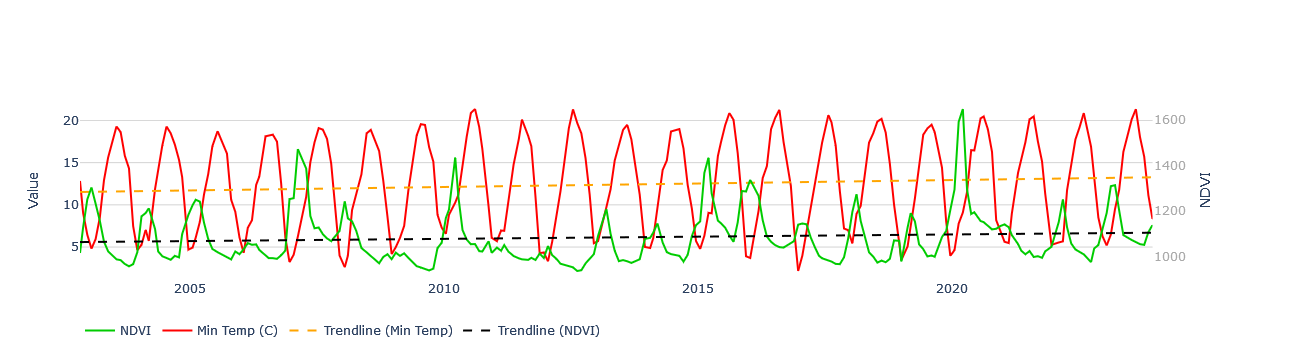

In [ ]:
# Plotly Regression Line

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression

# Load the data
data = pd.read_csv('./final_ds.csv', usecols=['Start Date','NDVI','Max Temp (C)','Min Temp (C)','Mean Moisture','Mean Wind Speed (M/Sec)','Precipitation (mm)'])

# Convert 'Start Date' to datetime format
data['Start Date'] = pd.to_datetime(data['Start Date'])
data['Month'] = data['Start Date'].dt.month
data['Year'] = data['Start Date'].dt.year

# Group by start date and calculate the mean
monthly_means = data.groupby(['Year','Month']).mean()
monthly_means.reset_index(inplace=True)

# Load the data (replace this with your actual data)
data = monthly_means

# Calculate linear regression for Min Temp
x = np.arange(len(data))
y = data['Min Temp (C)']
model = LinearRegression().fit(x.reshape(-1, 1), y)
trend_line = model.predict(x.reshape(-1, 1))

# Calculate linear regression for NDVI
x = np.arange(len(data))
y = data['NDVI']
model2 = LinearRegression().fit(x.reshape(-1, 1), y)
trend_line2 = model2.predict(x.reshape(-1, 1))

# Create a Plotly figure
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Define a custom brightened royal color palette
bright_royal_palette = [
    '#00cc00', '#0000ff', '#ff0000', '#e6e600', '#ff00ff', '#ff6600']

# Add traces for each numerical column
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
for i, column in zip(range(len(numerical_columns)), numerical_columns[:-1]):
    if column == 'Min Temp (C)':
        fig.add_trace(go.Scatter(x=data['Start Date'], y=data[column], mode='lines', name=column, line=dict(color=bright_royal_palette[i])), secondary_y=False)
    elif column == 'NDVI':
        fig.add_trace(go.Scatter(x=data['Start Date'], y=data[column], mode='lines', name=column, line=dict(color=bright_royal_palette[i])), secondary_y=True)

# Add linear trend line for Min Temp
fig.add_trace(go.Scatter(x=data['Start Date'], y=trend_line, mode='lines', name='Trendline (Min Temp)', line=dict(color='orange', dash='dash')), secondary_y=False)
fig.add_trace(go.Scatter(x=data['Start Date'], y=trend_line2, mode='lines', name='Trendline (NDVI)', line=dict(color='black', dash='dash')), secondary_y=True)

# Update layout for the plot
fig.update_layout(
    title_text='',#'Average Monthly Distribution of Variables (2002-2023)',
    title_x=0.5,  # Center the title
    xaxis=dict(title=''), #Start Date
    yaxis=dict(title='Value', showgrid=True, gridwidth=1, gridcolor='lightgrey', dtick=5),  # Add grid lines to y-axis with denser spacing (dtick=5)
    yaxis2=dict(title='NDVI', overlaying='y', side='right', tickfont=dict(color='darkgrey')),  # Customize secondary y-axis tick color
    legend=dict(x=0, y=-0.2, orientation='h'),  # Place legend at the bottom
    plot_bgcolor='white',  # Set plot background color
    paper_bgcolor='rgba(0,0,0,0)',  # Set paper background color (transparent)
    colorway=bright_royal_palette  # Apply the custom brightened royal color palette
)

# Show the interactive plot
fig.show()
fig.write_html('./Average Monthly Distribution of Variables - plotly_graph.html')

In [ ]:
import matplotlib.pyplot as plt

# Convert SHAP values to DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

# Scatter plot with SHAP as color axis
plt.scatter(X_test['Min Temp (C)'], X_test['Mean Moisture'], c=shap_df['Min Temp (C)'], cmap='magma', vmin=-25, vmax=80)
plt.colorbar(label='Min Temp (SHAP Color)')
plt.xlabel('Min Temp (C)')
plt.ylabel('Mean Moisture')
plt.show()

In [ ]:
# import os
# job_cancel_str="scancel " + os.environ['SLURM_JOBID']
# os.system(job_cancel_str)

'scancel 11350787'

In [ ]:
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd

# Assuming 'data' is your DataFrame containing the relevant columns
x = data[['Mean Wind Speed (M/Sec)', 'Min Temp (C)', 'Max Temp (C)']]
y = data['Mean Moisture']

# Fit the linear regression model
model = LinearRegression().fit(x, y)

# Calculate R-squared for each variable with the target value
r_squared_values = {}
for col in x.columns:
    # Create a DataFrame with the independent variable and the target variable
    temp_df = pd.DataFrame({col: x[col], 'Mean Moisture': y})
    # Fit a linear regression model using only the current independent variable
    temp_model = LinearRegression().fit(temp_df[[col]], temp_df['Mean Moisture'])
    # Calculate R-squared
    r_squared = r2_score(temp_df['Mean Moisture'], temp_model.predict(temp_df[[col]]))
    # Store the R-squared value
    r_squared_values[col] = r_squared

# Print R-squared values for each variable
for col, r_squared in r_squared_values.items():
    print(f"R-squared for {col}: {r_squared}")

R-squared for Mean Wind Speed (M/Sec): 0.25655908731150145
R-squared for Min Temp (C): 0.19375581966059086
R-squared for Max Temp (C): 0.3104591883837694


In [ ]:
data = pd.read_csv('./final_ds.csv')
data.describe()

,OBJECTID,Longitude,Latitude,Slope,Elevation,STRM_ORD_1,NDVI,Max Temp (C),Min Temp (C),Mean Moisture,Mean Wind Speed (M/Sec),Precipitation (mm)
count,645645.000000,645645.000000,645645.000000,645645.000000,645645.000000,645645.000000,645645.000000,645645.000000,645645.000000,645645.000000,645645.000000,645645.000000
mean,719.105708,34.794876,30.852693,10.716219,493.940914,1.034531,1085.079739,25.652623,12.434610,61.714377,2.841056,3.469890
std,412.984714,0.078411,0.067017,8.621458,116.844163,1.096895,170.470112,6.604307,5.595396,8.269345,0.464625,7.959958
min,1.000000,34.640108,30.718341,0.095698,207.404053,0.000000,62.000000,11.653333,0.813333,36.929630,1.654080,0.000000
25%,361.000000,34.731467,30.798895,3.556251,411.133697,0.000000,983.000000,19.566667,7.333333,55.985648,2.569352,0.000000
50%,722.000000,34.797050,30.852556,8.345725,510.494019,1.000000,1058.000000,26.413333,12.633333,61.978704,2.857131,0.000000
75%,1077.000000,34.858914,30.905346,16.036831,585.544739,1.000000,1154.000000,31.726667,17.826667,67.709722,3.067837,3.000000
max,1431.000000,34.946387,30.987248,57.944633,729.761353,6.000000,5185.000000,36.820000,22.686667,85.319049,5.293194,76.400000
